In [1]:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management and bonus visualization
import pandas as pd
import seaborn as sns

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [6]:
# global parameter
numepochs = 600

def trainTheModel(winenet):


  # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

  # loop over epochs
    for epochi in range(numepochs):

    # loop over training data batches
        winenet.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

      # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

      # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

      # loss from this batch
            batchLoss.append(loss.item())

      # compute training accuracy for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

    # test accuracy
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = winenet(X)
            testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
    return trainAcc,testAcc,losses

# Experiment: initialize weights and test model!

In [7]:
# create a model
winenet_xavier = ANNwine()

# change the weights (leave biases as kaiming[default])
for p in winenet_xavier.named_parameters():
    if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

# train the model and record its output
trainAcc_X,testAcc_X,losses_X = trainTheModel(winenet_xavier)

In [9]:
# create and train a model
winenet_kaiming = ANNwine()

# change the weights(leave biases as kaiming[default])
for p in winenet_kaiming.named_parameters():
    if 'weight' in p[0]:
        nn.init.kaiming_uniform_(p[1].data,nonlinearity='relu')

# train the model and record its output
trainAcc_K,testAcc_K,losses_K = trainTheModel(winenet_kaiming)



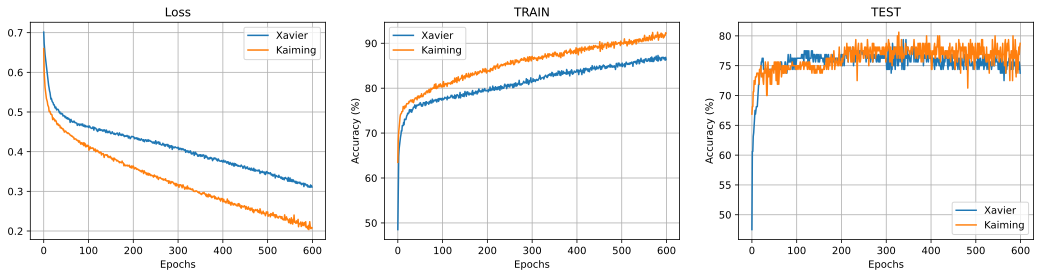

In [10]:
# plot the results

fig,ax = plt.subplots(1,3,figsize=(18,4))

# losses
ax[0].plot(losses_X,label='Xavier')
ax[0].plot(losses_K,label='Kaiming')
ax[0].set_title('Loss')

# train accuracy
ax[1].plot(trainAcc_X,label='Xavier')
ax[1].plot(trainAcc_K,label='Kaiming')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('TRAIN')

# test accuracy
ax[2].plot(testAcc_X,label='Xavier')
ax[2].plot(testAcc_K,label='Kaiming')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('TEST')

for i in range(3):
  ax[i].legend()
  ax[i].grid('on')
  ax[i].set_xlabel('Epochs')


plt.show()

# Repeat the experiment to get more stable results

In [14]:
#number of experiment iterations
numExps = 10




# dimensions of results:
#  1 - experiment run
#  2 - metric (loss/train/test)
#  3 - weight init (X/K)
results = np.zeros( (numExps,3,2) )


for expi in range(numExps):

  ### XAVIER
  # create a model and change the weights
  winenet_xavier = ANNwine()
  for p in winenet_xavier.named_parameters():
    if 'weight' in p[0]:
      nn.init.xavier_normal_(p[1].data)

  # train the model and record its output
  trainAcc_X,testAcc_X,losses_X = trainTheModel(winenet_xavier)


  ### KAIMING
  # create a model and change the weights
  winenet_kaiming = ANNwine()
  for p in winenet_kaiming.named_parameters():
    if 'weight' in p[0]:
      nn.init.kaiming_uniform_(p[1].data,nonlinearity='relu')

  # train the model and record its output
  trainAcc_K,testAcc_K,losses_K = trainTheModel(winenet_kaiming)


  ### collect the results!
  results[expi,0,0] = torch.mean(losses_X[-5:]).item()
  results[expi,0,1] = torch.mean(losses_K[-5:]).item()
  
  results[expi,1,0] = np.mean(trainAcc_X[-5:])
  results[expi,1,1] = np.mean(trainAcc_K[-5:])

  results[expi,2,0] = np.mean(testAcc_X[-5:])
  results[expi,2,1] = np.mean(testAcc_K[-5:])


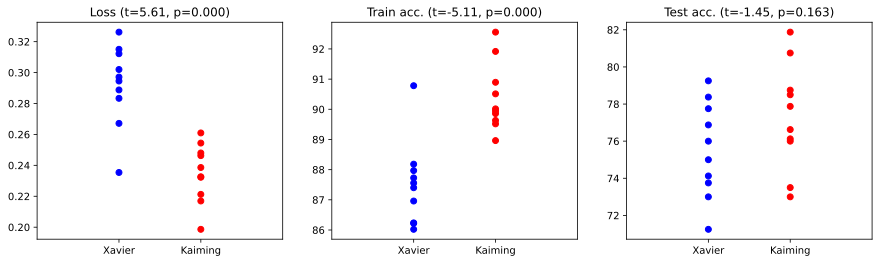

In [15]:
# And plot the results
fig,ax = plt.subplots(1,3,figsize=(15,4))

# plot titles
metric = ['Loss','Train acc.','Test acc.']

for i in range(3):
  
  # plot the results
  ax[i].plot(np.zeros(numExps),results[:,i,0],'bo')
  ax[i].plot(np.ones(numExps),results[:,i,1],'ro')
  
  # run a t-test to formalize the comparison
  t,p = stats.ttest_ind(results[:,i,0],results[:,i,1])
  title = '%s (t=%.2f, p=%.3f)' %(metric[i],t,p)

  
  # make the plot look a bit nicer
  ax[i].set_xlim([-1,2])
  ax[i].set_xticks([0,1])
  ax[i].set_xticklabels(['Xavier','Kaiming'])
  ax[i].set_title(title)

plt.show()